<a href="https://colab.research.google.com/github/tinayiluo0322/XAI_Projects/blob/main/Explainable_ML_I_RestNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #05
### Explainable_ML_I
### Luopeiwen Yi

# Exploring Explainable AI (XAI) Techniques for Image Classification with ResNet34

## Introduction

This notebook explores and compares various Explainable AI (XAI) techniques—**LIME**, **Anchors**, and **SHAP**—to explain the predictions made by a pre-trained **ResNet34** model for image classification. Specifically, a sample **bus image** is used, which the model misclassifies as a **passenger car**, and these XAI methods are applied to understand why the model made this incorrect prediction.

The notebook walks through the implementation of each explanation technique, highlighting their strengths and weaknesses. Each method is evaluated based on its interpretability, computational efficiency, and the clarity of its visualizations. In the end, **LIME** is selected as the preferred technique due to its intuitive explanations and computational efficiency.

Key components of this notebook include:
- **LIME Image Explainer**: Visualizes feature importance by highlighting regions of the image that influenced the model's prediction.
- **Anchors Explanation**: Provides rule-based explanations for the model's decision, focusing on specific image features.
- **SHAP Explanation**: Uses Shapley values to assess the contribution of each feature, though it is computationally intensive.

By the end of this notebook, we will gain a deeper understanding of how XAI techniques can be used to interpret the behavior of black-box models like ResNet34, and how these techniques compare in terms of effectiveness and usability in real-world image classification tasks.


In [1]:
import os

# Remove Colab default sample_data if it exists
if os.path.isdir("./sample_data"):
    !rm -r ./sample_data

# Clone GitHub repo (force re-clone if it already exists)
repo_name = "XAI_Projects"
git_path = 'https://github.com/tinayiluo0322/XAI_Projects.git'

if os.path.isdir(repo_name):
    !rm -rf "{repo_name}"
!git clone "{git_path}"

# Install dependencies from requirements.txt if it exists
#requirements_file = os.path.join(repo_name, 'requirements.txt')
#if os.path.isfile(requirements_file):
    #!pip install -r "{requirements_file}"
#else:
    #print("No requirements.txt found, skipping dependency installation.")

# Change working directory to location of notebook
notebook_dir = 'Explainable_ML_I'
path_to_notebook = os.path.join(repo_name, notebook_dir)

# Check if the directory exists
if os.path.isdir(path_to_notebook):
    %cd "{path_to_notebook}"
    %ls
else:
    print(f"Directory {path_to_notebook} not found")

Cloning into 'XAI_Projects'...
remote: Enumerating objects: 6117, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 6117 (delta 17), reused 6 (delta 6), pack-reused 6078 (from 1)
Receiving objects: 100% (6117/6117), 102.61 MiB | 13.85 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/XAI_Projects/Explainable_ML_I
Placeholder


In [2]:
import os
import shutil
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import json
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from IPython.display import display
!pip install Pillow
import cv2
from google.colab.patches import cv2_imshow
!pip install shap torch torchvision pillow
import shap
import warnings
warnings.filterwarnings("ignore")
!pip install alibi
from alibi.explainers import AnchorImage
from google.colab import output
output.enable_custom_widget_manager()
from google.colab import drive
import torch.backends.cudnn as cudnn
import matplotlib.patches as patches
from torchvision.models import resnet34
from torchvision.models.resnet import ResNet, BasicBlock
import pickle
import requests
import json
import shap
import tensorflow as tf
!pip install keras-resnet
import keras_resnet.models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input
import keras_resnet.models
from scipy.ndimage import zoom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b20217e20346cbfa335000c1a7f02775c5aef180b686a7cac18b151a2586ea35
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 24.2.0
    Uninstalling attrs-24.2.0:
      Succ

Check GPU Availability

In [3]:
# Set a seed for reproducibility
seed = 42

# For Python's random module
random.seed(seed)

# For NumPy
np.random.seed(seed)

# For PyTorch
torch.manual_seed(seed)

# Set the seed for CUDA
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # use multi-GPU.

In [4]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using device: cuda
Using GPU: NVIDIA L4


## ResNet34 Model Prediction

I'll be using the pre-trained ResNet34 model for image classification, with a bus image as the sample input.

Mounted at /content/drive


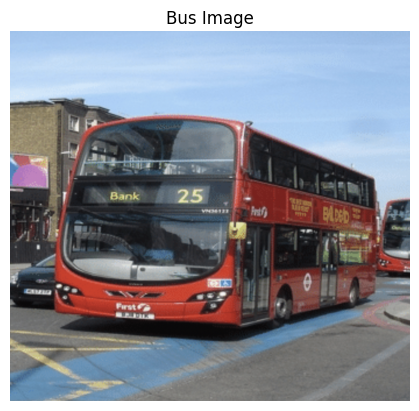

Image Size: (1125, 1040)
Image Mode: RGBA


In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the image from Google Drive
image_path = '/content/drive/My Drive/bus.png'
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.title("Bus Image")
plt.show()

# print the image details (size, mode, etc.)
print(f"Image Size: {image.size}")
print(f"Image Mode: {image.mode}")

In [6]:
# Convert the image to RGB if it has an alpha channel (4 channels)
if image.mode != 'RGB':
    image = image.convert('RGB')

# Preprocessing function for the image (similar to ImageNet preprocessing)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess the image
input_image = preprocess(image)
input_image = input_image.unsqueeze(0)  # Add batch dimension

In [7]:
# Load a pretrained ResNet model
model = models.resnet34(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Use the model to make a prediction
with torch.no_grad():
    output = model(input_image)

# Get the predicted class
_, predicted_class = torch.max(output, 1)
print(f'Predicted Class Index: {predicted_class.item()}')

# Load ImageNet class labels
import json
!wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
with open("imagenet-simple-labels.json") as f:
    labels = json.load(f)

# Print the predicted class label
predicted_label = labels[predicted_class.item()]
print(f'Predicted Label: {predicted_label}')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 181MB/s]


Predicted Class Index: 705
--2024-10-02 01:30:29--  https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14209 (14K) [text/plain]
Saving to: ‘imagenet-simple-labels.json’

imagenet-simple-lab 100%[===================>]  13.88K  --.-KB/s    in 0s      

2024-10-02 01:30:29 (133 MB/s) - ‘imagenet-simple-labels.json’ saved [14209/14209]

Predicted Label: passenger car


It seems that ResNet34 has incorrectly classified the bus image as a passenger car. Why did this happen, and how did the model arrive at this prediction? Let's explore with some XAI techniques to find out!

## LIME

LIME is a technique that explains the predictions of any black-box machine learning model by approximating its behavior locally (near the instance of interest) using a simple interpretable model like linear regression or decision trees. The goal is to explain why a model made a particular prediction for a specific data point, rather than understanding the global behavior of the model. LIME approximates the decision function around the instance of interest using a linear model or some other simple interpretable model.

### Summary of Pros and Cons for LIME

| **Aspect**              | **Pros**                                                                 | **Cons**                                                                                          |
|-------------------------|-------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Interpretability**     | Provides **feature importance scores** that are intuitive and easy to understand | Explanations can be **inconsistent** across settings or experiments, leading to **instability**    |
| **Model Agnosticism**    | **Flexible** – can be applied to any black-box model, even if the model is replaced | Can struggle with **nonlinear decision boundaries** due to its use of linear approximations         |
| **Flexibility**          | Works well with **tabular data, text, and images**                        | **Defining the neighborhood** and optimizing the kernel width can be difficult                     |
| **Efficiency**           | Provides **local explanations** without requiring a global model to be retrained | Can be **computationally expensive** when a large number of perturbations is required              |
| **Local Approximation**  | Approximates the **local decision boundary** around the instance, making it simple | May provide **oversimplified explanations**, missing complex model behavior                        |
| **Bias**                 | Can work with various data types and models, remaining **intuitive**      | Can be **fooled** or used to **hide biases**, as the explanation may focus on irrelevant features  |

### Lime Image Explainer (The method being used for the bus example)

[lime 0.1 documentation](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image)

The LIME Image Explainer (Local Interpretable Model-agnostic Explanations) is a technique designed to explain the predictions of black-box models for image classification tasks. It works by perturbing the original image—typically by segmenting the image into superpixels (small regions of similar pixels) and selectively altering these regions to create multiple perturbed versions of the image. The model’s predictions for these perturbed images are then used to train an interpretable local surrogate model, such as a linear classifier, which approximates the model's behavior in the vicinity of the original image. LIME highlights the most important regions of the image that contributed to the model's prediction, providing human-understandable visual explanations for complex models like neural networks. This approach is especially useful for understanding why certain parts of an image strongly influenced the model’s classification decision.

### Summary of Pros and Cons for LIME Image Explainer

| **Aspect**              | **Pros**                                                                 | **Cons**                                                                                          |
|-------------------------|-------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Interpretability**     | Provides **visual explanations** by highlighting important image regions, making it intuitive | Explanations can be **inconsistent** across different image perturbations, leading to **instability** |
| **Model Agnosticism**    | **Flexible** – can be applied to any black-box image classifier, regardless of the model architecture | May struggle with highly **nonlinear decision boundaries** due to its linear approximations        |
| **Flexibility**          | Works well with **various image classification models**                   | Requires **careful tuning** of the perturbation process (e.g., superpixel size)                     |
| **Efficiency**           | Provides **local explanations** for specific images without retraining the model | Can be **computationally expensive** when a large number of image perturbations are required       |
| **Local Approximation**  | Approximates the **local decision boundary** of the model for each image   | May lead to **oversimplified explanations**, failing to capture complex model behaviors            |
| **Bias**                 | Provides **intuitive visual cues** for feature importance in images        | Can be **fooled** or manipulated to highlight **irrelevant regions**, leading to biased explanations |



  0%|          | 0/1000 [00:00<?, ?it/s]

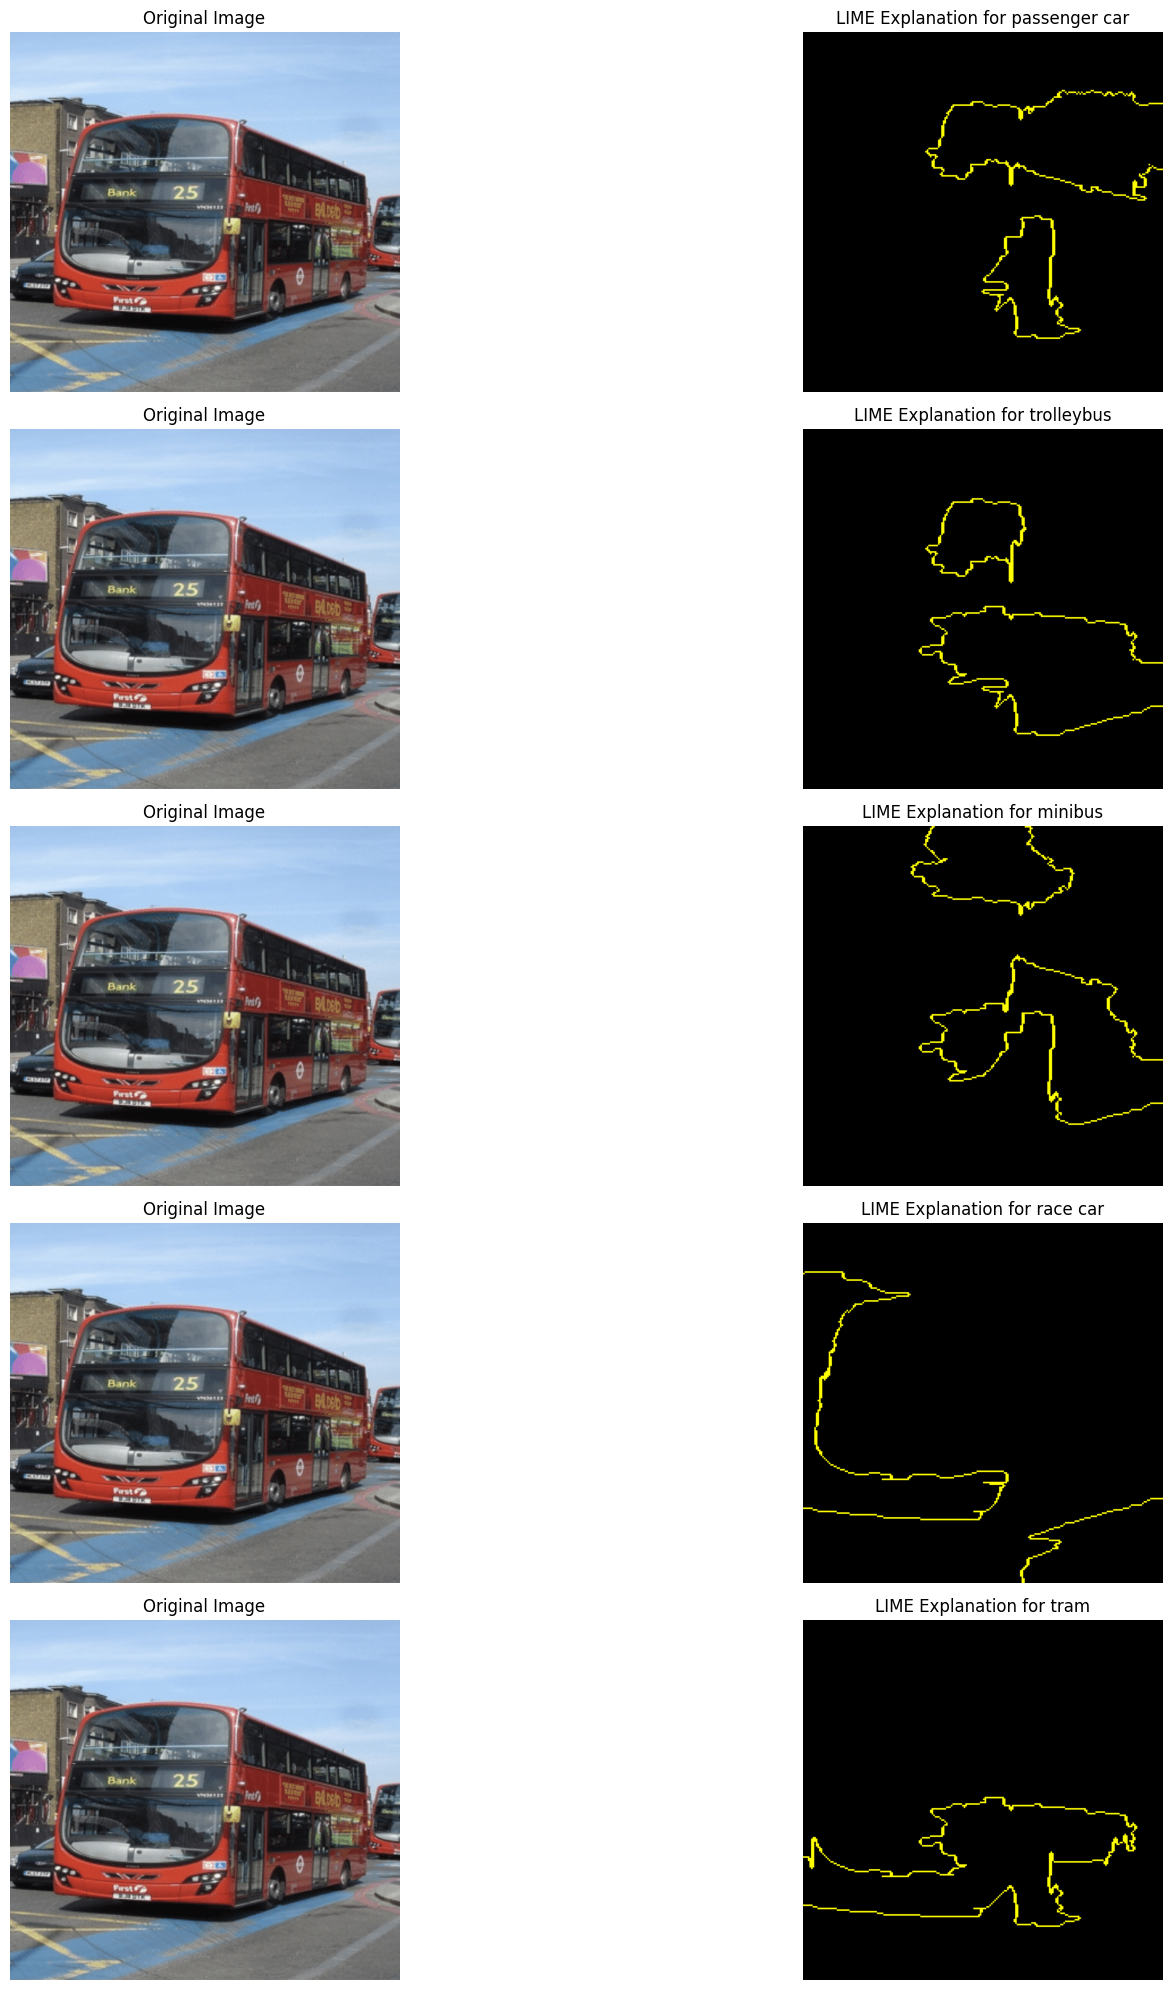

Top 5 predictions:
passenger car: 0.7677
trolleybus: 0.2194
minibus: 0.0028
race car: 0.0021
tram: 0.0015


In [ ]:
def get_preprocess_transform():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_input_transform():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

preprocess_transform = get_preprocess_transform()
input_transform = get_input_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(Image.fromarray((img * 255).astype(np.uint8))) for img in images), dim=0)

    device = next(model.parameters()).device
    batch = batch.to(device)

    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

# Load and preprocess the image
image_path = '/content/drive/My Drive/bus.png'
img = Image.open(image_path)
if img.mode != 'RGB':
    img = img.convert('RGB')
input_img = input_transform(img)

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer(random_state=42)

# Get the explanation
explanation = explainer.explain_instance(
    np.array(input_img.permute(1, 2, 0)),
    batch_predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

# Visualize the explanations for top 5 classes
plt.figure(figsize=(20, 4*5))
for idx, label in enumerate(explanation.top_labels):
    temp, mask = explanation.get_image_and_mask(
        label, positive_only=True, num_features=5, hide_rest=True
    )
    img_boundary = mark_boundaries(temp/255.0, mask)

    plt.subplot(5, 2, 2*idx+1)
    plt.imshow(img)
    plt.title(f'Original Image')
    plt.axis('off')

    plt.subplot(5, 2, 2*idx+2)
    plt.imshow(img_boundary)
    plt.title(f'LIME Explanation for {labels[label]}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/XAI_sample/lime_explanation_top5.png')
plt.show()

# Print the top 5 predictions with their probabilities
print("Top 5 predictions:")
probs = batch_predict(np.expand_dims(np.array(input_img.permute(1, 2, 0)), axis=0))[0]
top5_idx = probs.argsort()[-5:][::-1]
for idx in top5_idx:
    print(f"{labels[idx]}: {probs[idx]:.4f}")

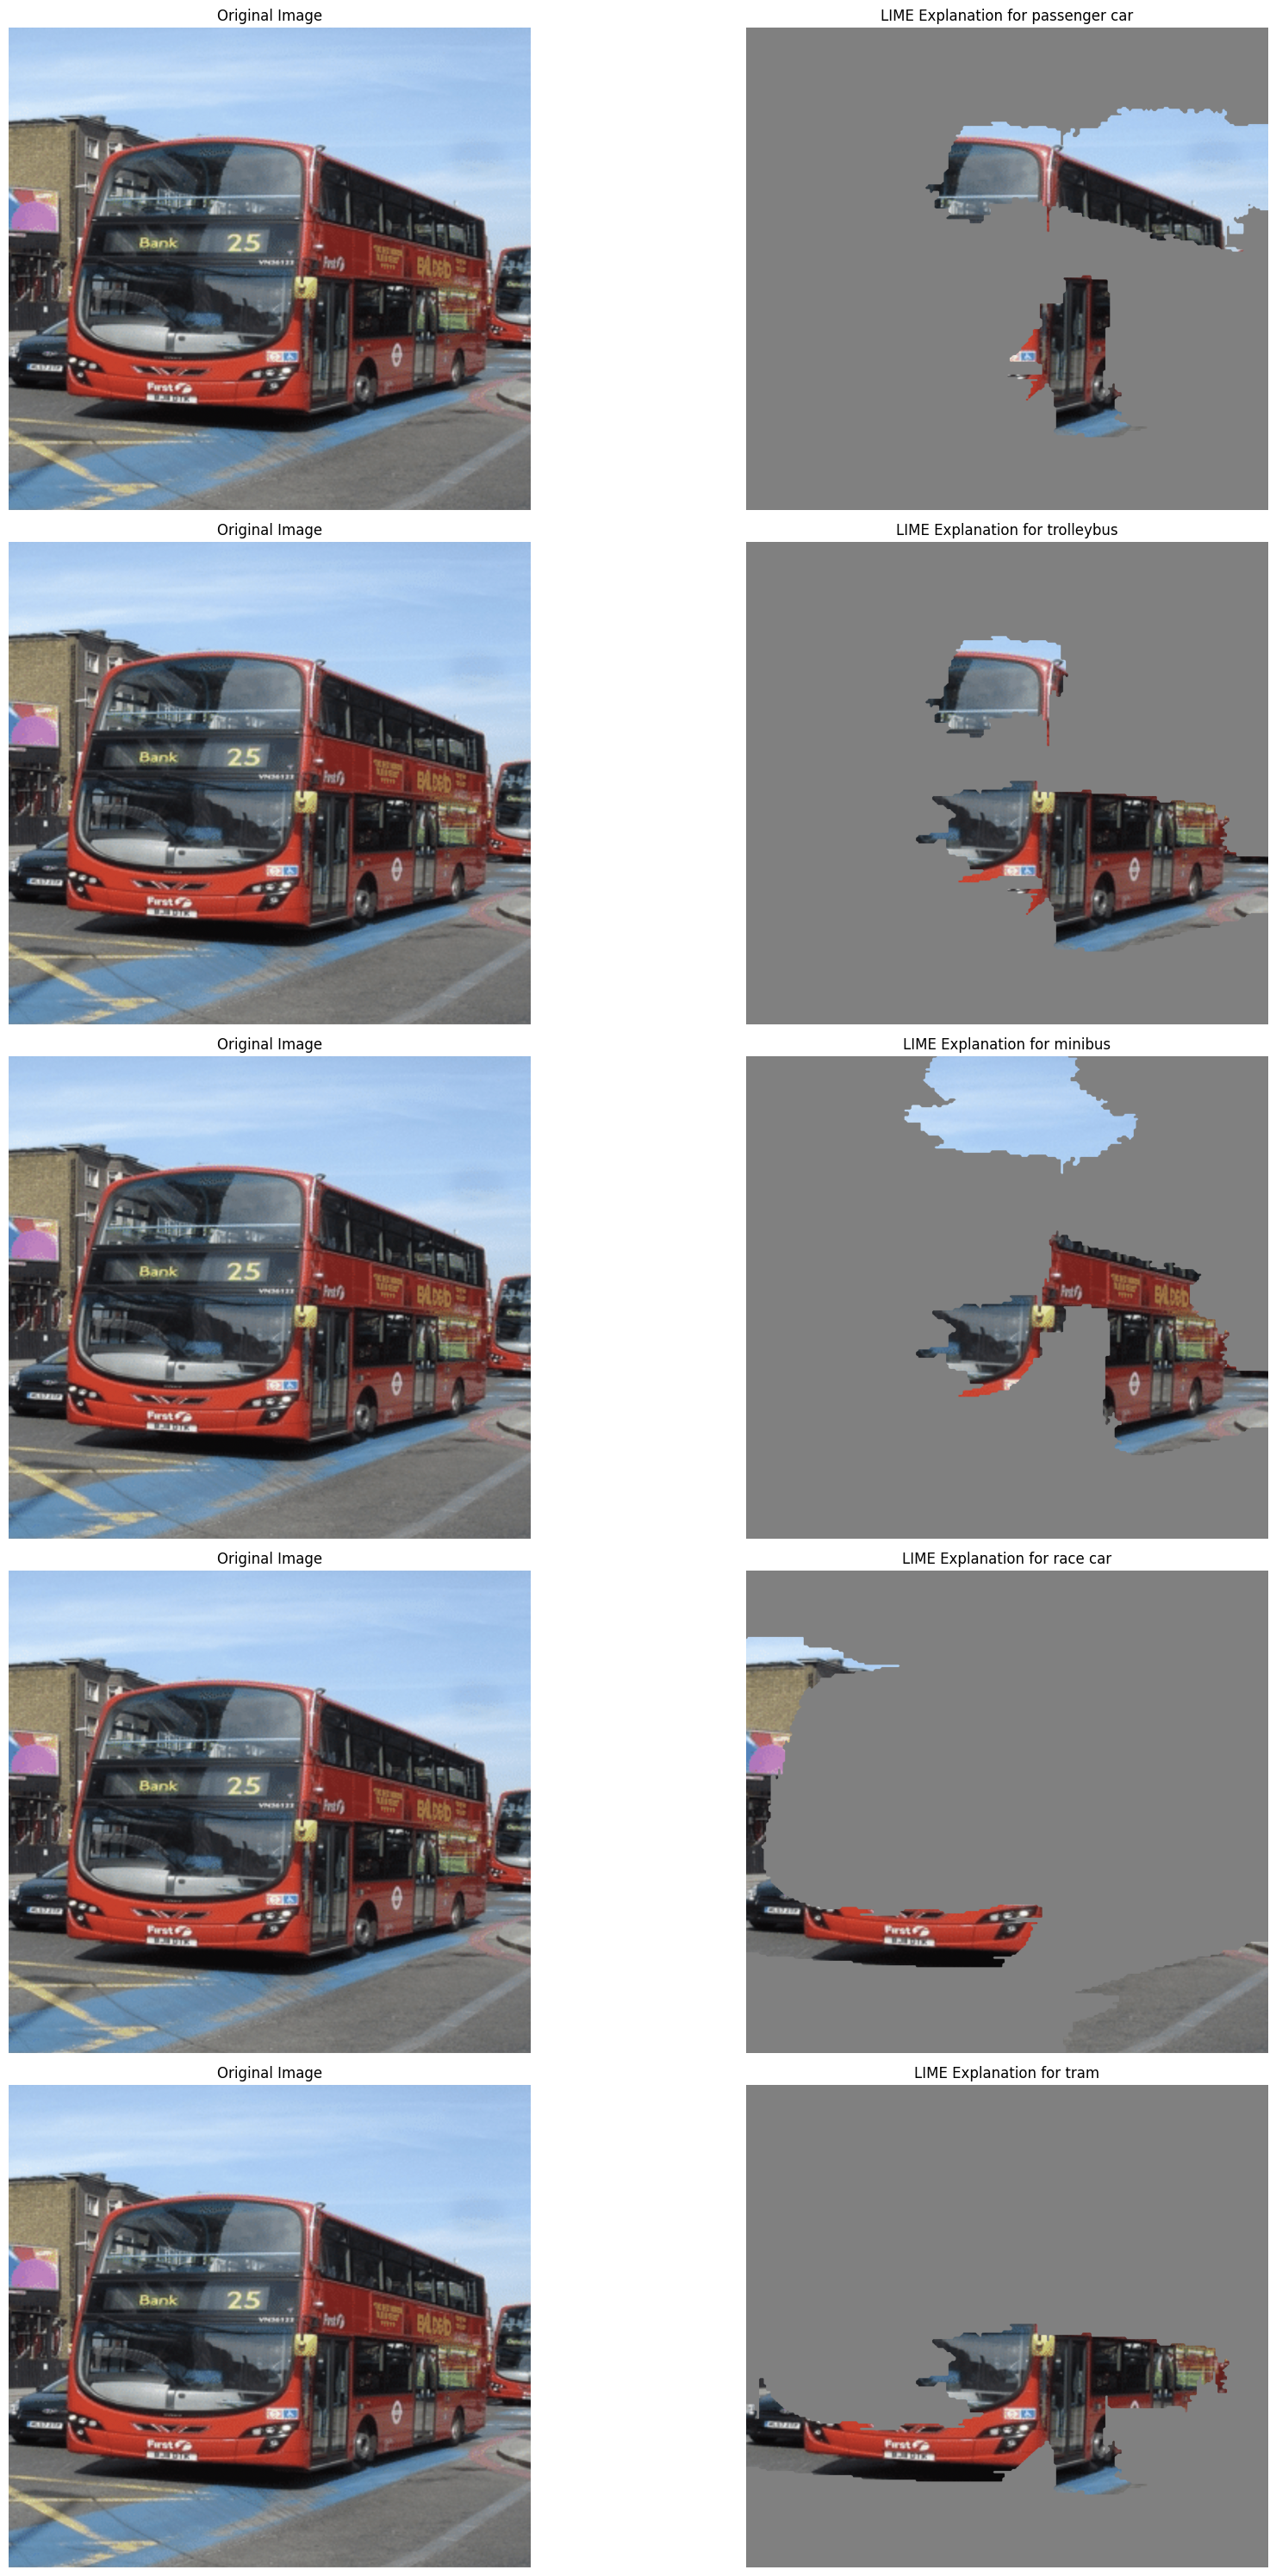

Top 5 predictions:
passenger car: 0.7677
trolleybus: 0.2194
minibus: 0.0028
race car: 0.0021
tram: 0.0015


In [49]:
# Function to create perturbation visualization
def perturbation_visualization(image, mask):
    # Resize mask to match image dimensions
    mask_resized = zoom(mask, (image.size[1] / mask.shape[0], image.size[0] / mask.shape[1]), order=1)
    mask_resized = np.clip(mask_resized, 0, 1)  # Ensure values are between 0 and 1

    # Create a gray image
    gray_color = (128, 128, 128)  # Mid-gray color
    gray_image = Image.new('RGB', image.size, gray_color)

    # Create the overlay
    image_array = np.array(image)
    gray_array = np.array(gray_image)
    mask_3d = np.expand_dims(mask_resized, axis=2)
    overlay = (image_array * mask_3d + gray_array * (1 - mask_3d)).astype(np.uint8)

    return Image.fromarray(overlay)

# Visualize the explanations for top 5 classes
plt.figure(figsize=(20, 6*5))
for idx, label in enumerate(explanation.top_labels):
    temp, mask = explanation.get_image_and_mask(
        label, positive_only=True, num_features=5, hide_rest=False
    )

    perturbed_img = perturbation_visualization(img, mask)

    plt.subplot(5, 2, 2*idx+1)
    plt.imshow(img)
    plt.title(f'Original Image')
    plt.axis('off')

    plt.subplot(5, 2, 2*idx+2)
    plt.imshow(perturbed_img)
    plt.title(f'LIME Explanation for {labels[label]}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/XAI_sample/lime_explanation_full_gray_perturbation_top5.png')
plt.show()

# Print the top 5 predictions with their probabilities
print("Top 5 predictions:")
probs = batch_predict(np.expand_dims(np.array(input_img.permute(1, 2, 0)), axis=0))[0]
top5_idx = probs.argsort()[-5:][::-1]
for idx in top5_idx:
    print(f"{labels[idx]}: {probs[idx]:.4f}")

### Evaluation of the LIME Explanation

The LIME explanation provides clear insights into how ResNet34 makes its top 5 predictions.

- **Passenger car**: The ResNet34 model predicts a 76.77% probability that the image is a passenger car, making it the top predicted class. From the LIME explanation, we can observe that the model focused on the bus door, the wheel, the upper side bus windows, and the sky. This is logical because, when picture those features together, these features resemble those of a passenger car.

- **Trolleybus**: The model predicts a 21.94% probability for the image being a trolleybus. The LIME explanation shows that the model focused on the large front bus window and the lower side features along the entire length of the bus, such as the door, wheels, side windows, and rearview mirror. This makes sense as trolleybuses typically have a long structure, and the model has captured those characteristics.

- **Minibus**: With a 0.28% prediction for a minibus, the model focused on the sky, features along the lower and middle sections along the entire length of the bus (door, wheels, side windows, rearview mirror), the slogan on the side, and part of the front window. Although this prediction has a low probability, it is the most accurate for a bus, as it captures the essential features of a bus.

- **Racecar**: The model predicts a 0.21% probability that the image is a racecar. The LIME explanation reveals that this prediction is based on the bus’s bumper and a black car beside the bus near a building. This is understandable, as focusing on just that part of the image could lead one to mistake it for a racecar.

- **Tram**: The model predicts a 0.15% probability for the image being a tram. LIME shows that the model focused on the bus’s bumper, along with features from the lower and middle parts of the bus, such as the door, wheels, side windows, rearview mirror, and half of the front window. These features are similar to those found on a tram, explaining the model’s prediction.

Overall, LIME provides a solid explanation for how the ResNet34 model is making its predictions. The visualizations are clear, with irrelevant parts of the image grayed out, highlighting only the most important features considered by the model for each class prediction.


## Anchors Explaination

Anchors is a type of if-then rule used to explain individual predictions made by machine learning models. Unlike LIME, which approximates complex decision boundaries using local linear models, Anchors provide decision rules that "anchor" the prediction to certain features or conditions. When these conditions hold true, the model’s prediction remains consistent with high probability, even if other features change.

### Summary of Pros and Cons for Anchors

| **Aspect**              | **Pros**                                                       | **Cons**                                                                                          |
|-------------------------|---------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Interpretability**     | Rules are easy to understand—if-then format is intuitive      | Requires careful parameter tuning, which can be challenging                                        |
| **Handling Complexity**  | Works well with nonlinear or complex models                   | Perturbation function needs to be custom-designed for each specific use case                       |
| **Model Agnosticism**    | Can be used with any model, model agnostic        | Coverage is hard to define and measure in some domains, making it difficult to compare             |
| **Efficiency**           | Highly efficient search algorithms like beam search           | Imbalanced data can result in biased perturbation spaces unless careful mitigation is used         |

### AnchorImage (The method being used for the bus example)

[alibi.explainers.anchors.anchor_image module documentation](https://docs.seldon.io/projects/alibi/en/latest/api/alibi.explainers.anchors.anchor_image.html)

The AnchorImage explainer is an extension of the Anchors approach designed specifically for image classification tasks, providing highly interpretable, rule-based explanations for predictions made by complex models such as deep neural networks. Instead of relying on global model behavior or linear approximations, AnchorImage identifies if-then rules that are based on superpixels, or segmented regions of the image. These anchors represent key areas of the image that, when present, strongly influence the model’s prediction. The method generates a set of perturbed images by altering different regions, and it tests whether the model’s prediction remains consistent when the anchor region is unchanged. This allows AnchorImage to provide a highly stable and visual explanation by highlighting the specific areas of the image responsible for the model’s decision, making it an effective tool for understanding predictions in complex models like convolutional neural networks (CNNs).

### Summary of Pros and Cons for AnchorImage Explainer

| **Aspect**              | **Pros**                                                                 | **Cons**                                                                                          |
|-------------------------|-------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Interpretability**     | Provides easy-to-understand **if-then rules** based on image superpixels, making visual explanations intuitive | Requires **careful parameter tuning** for perturbations, such as defining superpixels and thresholds |
| **Handling Complexity**  | Works well with **nonlinear and complex models**, such as deep neural networks | Perturbation function and superpixel segmentation need to be **custom-designed** for each image dataset |
| **Model Agnosticism**    | Can be used with **any image classification model**, remaining model-agnostic | **Coverage** can be hard to measure, and it is difficult to define in certain domains               |
| **Efficiency**           | Uses **efficient search algorithms** like beam search to find anchor regions | **Computationally expensive** when generating and testing a large number of image perturbations     |
| **Stability**            | Provides **stable explanations** by identifying key superpixels that consistently influence predictions | **Imbalanced data** can lead to anchors focusing on irrelevant regions or failing to generalize     |


In [9]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')
    return transform(img).unsqueeze(0)

def predict_fn(images):
    model.eval()
    with torch.no_grad():
        if isinstance(images, np.ndarray):
            images = torch.from_numpy(images).permute(0, 3, 1, 2).float()
        outputs = model(images)
    return outputs.numpy()

# Load and preprocess the image
image_path = '/content/drive/My Drive/bus.png'  # Update this path
input_tensor = preprocess_image(image_path)
input_image = input_tensor.squeeze().permute(1, 2, 0).numpy()

# Initialize the AnchorImage explainer
explainer = AnchorImage(
    predict_fn,
    image_shape=input_image.shape,
    segmentation_fn='quickshift',
    segmentation_kwargs={'kernel_size': 4, 'max_dist': 200, 'ratio': 0.2},
    images_background=None,
    seed=42
)

# Generate the explanation
explanation = explainer.explain(input_image, threshold=0.95, p_sample=0.5, tau=0.25)

Image shape: (224, 224, 3)
Segments shape: (224, 224)
Anchor shape: (224, 224, 3)
Processed segments shape: (224, 224)


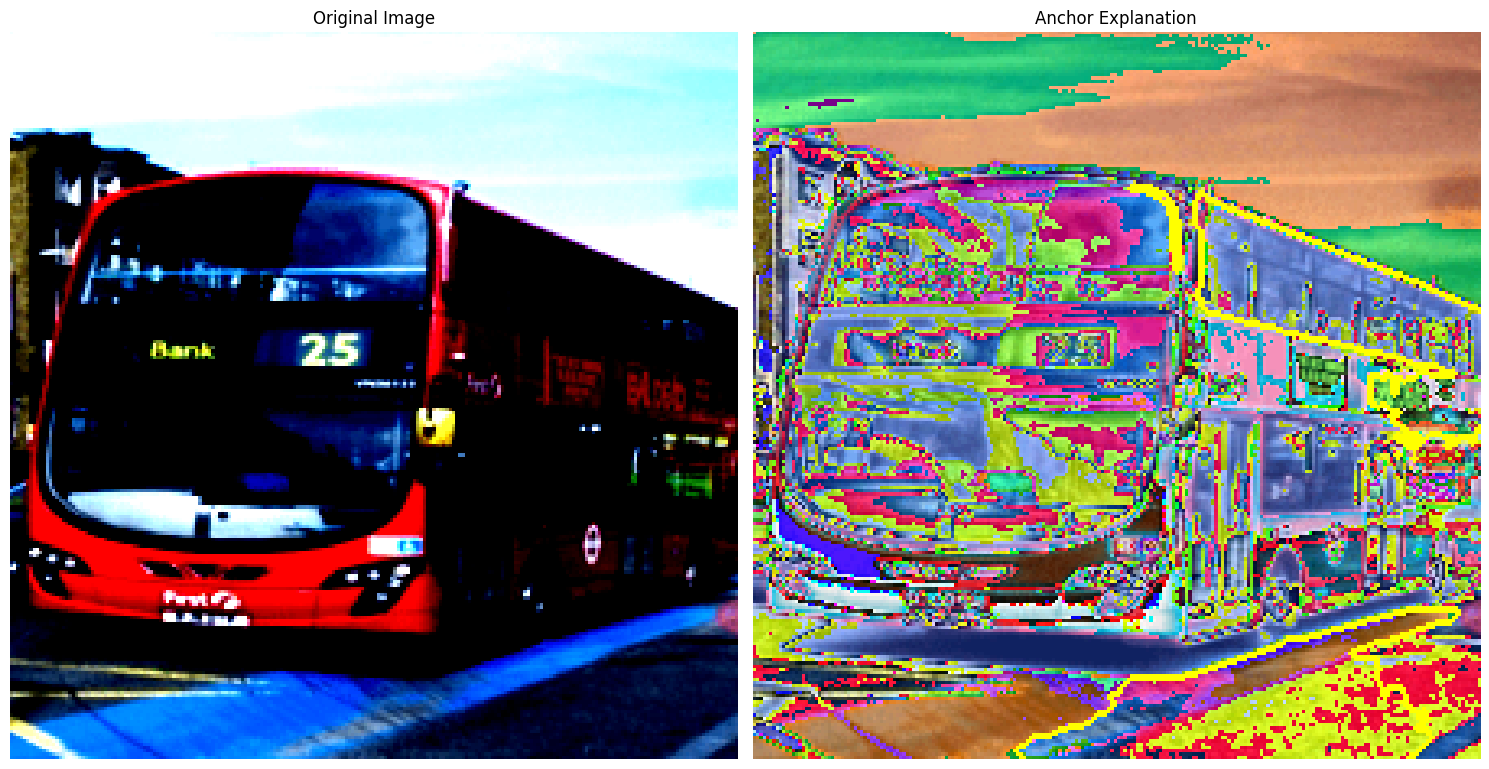

SHAP explanation plot saved to /content/drive/My Drive/XAI_sample/anchor_explanation.png


<Figure size 640x480 with 0 Axes>

In [10]:
def visualize_anchor(image, exp, fig_size=(15, 15)):
    anchor = exp.anchor
    segments = exp.segments

    print(f"Image shape: {image.shape}")
    print(f"Segments shape: {segments.shape}")
    print(f"Anchor shape: {anchor.shape}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)

    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Ensure segments is 2D
    if segments.ndim == 3:
        segments = segments[:,:,0]
    print(f"Processed segments shape: {segments.shape}")

    # Create a boolean mask for the anchor
    temp_img = np.zeros(segments.shape, dtype=bool)
    if anchor.ndim == 3:
        # If anchor is 3D, we assume it's a boolean mask
        temp_img = anchor[:,:,0].astype(bool)
    elif anchor.ndim == 1:
        # If anchor is 1D, we assume it's a list of segment indices
        for seg_idx in anchor:
            temp_img[segments == seg_idx] = True
    else:
        print("Unexpected anchor shape. Please check the anchor data.")

    # Ensure image is in the correct format for mark_boundaries
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    highlighted_img = mark_boundaries(image, temp_img, color=(1, 1, 0), mode='thick')
    ax2.imshow(highlighted_img)
    ax2.set_title('Anchor Explanation')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the plot
    plt.savefig('/content/drive/My Drive/XAI_sample/anchor_explanation.png')
    print("SHAP explanation plot saved to /content/drive/My Drive/XAI_sample/anchor_explanation.png")

# Usage example:
visualize_anchor(input_image, explanation)

In [11]:
def load_imagenet_classes():
    url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
    fname = shap.datasets.cache(url)
    with open(fname) as f:
        class_names = json.load(f)
    return {int(key): value[1] for key, value in class_names.items()}

imagenet_classes = load_imagenet_classes()

def print_simple_anchor_explanation(explanation):
    pred_class = explanation.raw['prediction']

    # Handle the case where pred_class is a numpy array
    if isinstance(pred_class, np.ndarray):
        pred_class = pred_class.item() if pred_class.size == 1 else pred_class.tolist()

    # Try to get the class name, if pred_class is a single integer
    if isinstance(pred_class, int):
        class_name = imagenet_classes.get(pred_class, "Unknown")
        print(f"\nPredicted class: {pred_class} ({class_name})")
    else:
        print(f"\nPredicted class: {pred_class}")

    print(f"Anchor precision: {explanation.precision:.2f}")
    print(f"Anchor coverage: {explanation.coverage:.2f}")

Image shape: (224, 224, 3)
Segments shape: (224, 224)
Anchor shape: (224, 224, 3)
Processed segments shape: (224, 224)


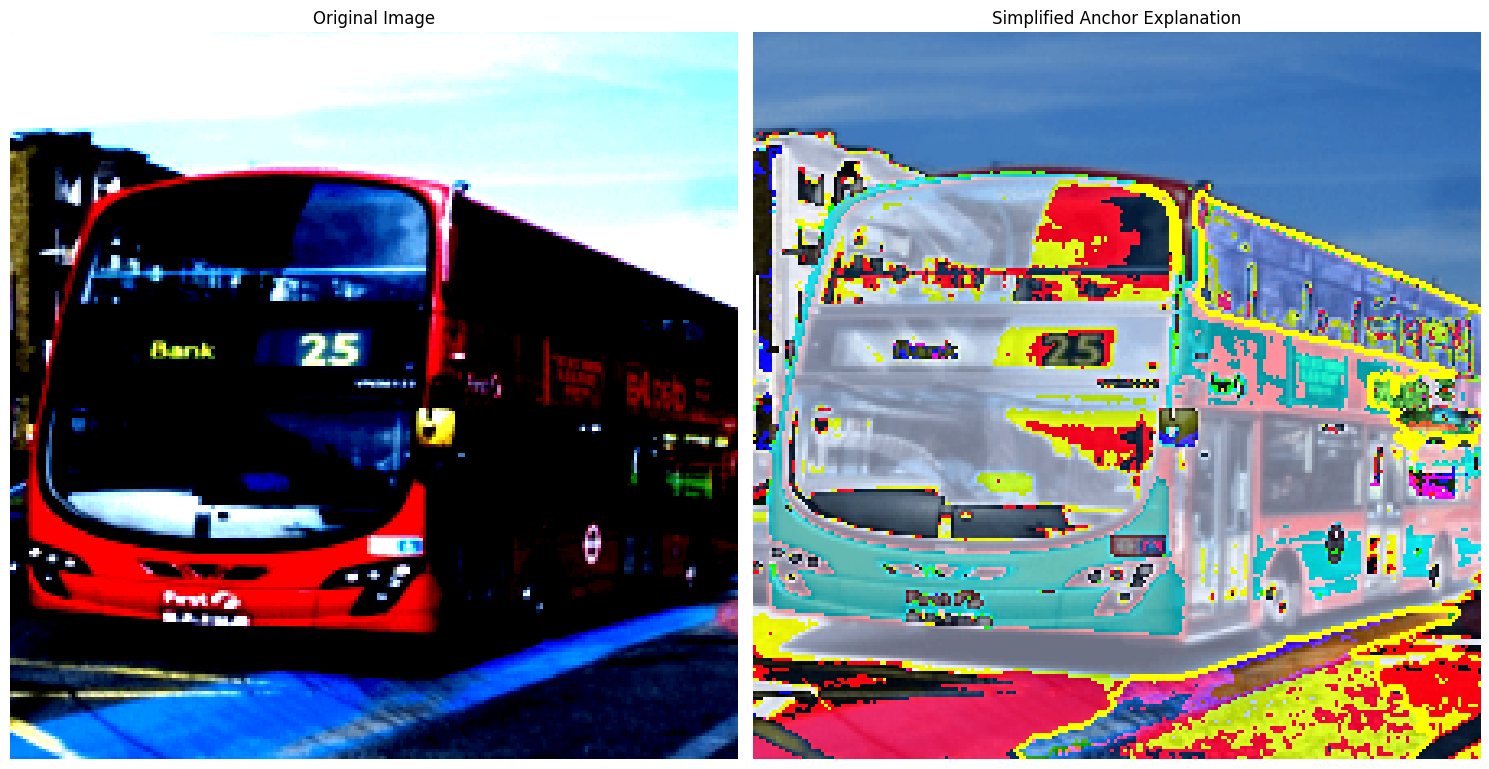

Simplified anchor explanation plot saved to /content/drive/My Drive/XAI_sample/simplified_anchor_explanation.png

Predicted class: 705 (passenger_car)
Anchor precision: 0.99
Anchor coverage: 0.25


<Figure size 640x480 with 0 Axes>

In [12]:
def visualize_simplified_anchor(image, exp, fig_size=(15, 15)):
    anchor = exp.anchor
    segments = exp.segments

    print(f"Image shape: {image.shape}")
    print(f"Segments shape: {segments.shape}")
    print(f"Anchor shape: {anchor.shape}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)

    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Ensure segments is 2D
    if segments.ndim == 3:
        segments = segments[:,:,0]
    print(f"Processed segments shape: {segments.shape}")

    # Create a boolean mask for the anchor
    temp_img = np.zeros(segments.shape, dtype=bool)
    if anchor.ndim == 3:
        # If anchor is 3D, we assume it's a boolean mask
        temp_img = anchor[:,:,0].astype(bool)
    elif anchor.ndim == 1:
        # If anchor is 1D, we assume it's a list of segment indices
        for seg_idx in anchor:
            temp_img[segments == seg_idx] = True
    else:
        print("Unexpected anchor shape. Please check the anchor data.")

    # Simplify the visualization
    simplified_img = image.copy()
    simplified_img[~temp_img] = simplified_img[~temp_img] * 0.3  # Darken non-anchor regions

    # Ensure image is in the correct format for mark_boundaries
    if simplified_img.dtype != np.uint8:
        simplified_img = (simplified_img * 255).astype(np.uint8)

    highlighted_img = mark_boundaries(simplified_img, temp_img, color=(1, 1, 0), mode='thick')
    ax2.imshow(highlighted_img)
    ax2.set_title('Simplified Anchor Explanation')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the plot
    save_path = '/content/drive/My Drive/XAI_sample/simplified_anchor_explanation.png'
    plt.savefig(save_path)
    print(f"Simplified anchor explanation plot saved to {save_path}")

visualize_simplified_anchor(input_image, explanation)
print_simple_anchor_explanation(explanation)

### Evaluation of the Anchors Explanation

In the simplified Anchors visualization (as the original was cluttered with too many colors and difficult to interpret), we can observe how ResNet34 predicts the bus image to be a passenger car. The model focuses on specific areas, such as part of the bus's upper front window, the large bus number, and the majority of the bus's iron sheet body. Interestingly, it ignores significant features such as the bus's entire front windows, the upper and lower side windows, the wheels, and the door—all of which are completely grayed out. There is also notable focus on the road, which makes some sense, as a road paired with a metal structure resembling a car could reasonably lead to a passenger car prediction.

Looking at the anchor precision of **0.99**, we can see that the anchor rule is highly reliable—99% of the time, when the anchor conditions hold, the model makes the same prediction. This suggests that the features highlighted by the anchor are critical to the model’s decision-making. However, the anchor coverage is **0.25**, meaning that this rule applies to only 25% of similar instances. While the explanation is precise, it is relatively specific and doesn’t generalize widely across other examples.

Overall, while Anchors provides a reasonable explanation with high precision, the visualization is less intuitive compared to LIME. It’s noteworthy that Anchors is designed to address some of LIME’s limitations by offering a more robust explanation, yet the resulting visualization can feel less clear and interpretable in practice.

## SHAP Explaination

SHAP values are based on the idea of Shapley values from game theory, which fairly distribute the difference between the model's prediction for an instance and a baseline (such as the average prediction across all instances) among the individual feature values.
SHAP uses this concept to explain the marginal contribution of each feature to the prediction.

### Summary of Pros and Cons for SHAP

| **Aspect**              | **Pros**                                                                                               | **Cons**                                                                                           |
|-------------------------|-------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------|
| **Fairness in Feature Attribution** | SHAP fairly distributes the difference between the **prediction and average prediction** among the feature values | **Extremely slow** to compute, especially for complex models or large datasets                     |
| **Contrastive Explanations**        | Enables **contrastive explanations**, allowing comparisons to the average prediction, subsets, or even specific data points | Requires **access to the full dataset** to accurately calculate baseline predictions                |
| **Model-Agnostic**       | SHAP is **model-agnostic**, applicable to any type of machine learning model                          | Can be **misused to create misleading interpretations** or hide biases by manipulating feature attributions |
| **Consistency**          | SHAP guarantees **consistency**, meaning that if a model changes such that a feature’s contribution increases, its SHAP value will also increase | Computationally expensive, especially for models with many features or complex decision boundaries  |
| **Robust Explanations**  | Provides **robust and interpretable explanations** that account for both individual and global feature contributions | Can be **challenging to interpret** for non-technical users if not simplified properly              |


### SHAP Deep Explainer (Not used here for the Bus example due to constraints in gradient calculation within ResNet34's internal architecture)

The SHAP Deep Explainer is a specialized version of SHAP (SHapley Additive exPlanations) designed to explain predictions made by deep learning models, such as neural networks. It leverages DeepLIFT (Deep Learning Important FeaTures) and the properties of Shapley values to provide more accurate and efficient explanations for complex, nonlinear models. The Deep Explainer uses backpropagation to attribute the contribution of each input feature to the model's output, making it well-suited for deep networks where traditional methods like linear approximations (e.g., LIME) may fall short. It is particularly effective for models built with frameworks like TensorFlow and Keras.

I'm not using the SHAP Deep Explainer approach in this case due to constraints related to the gradient calculation within the internal architecture of the ResNet34 model. Specifically, there is an issue where the BackwardHookFunctionBackward generates an output that is a view and is being modified in-place. This view, created inside a custom function, can interfere with the autograd mechanism used to calculate gradients, potentially leading to incorrect gradients. Since this behavior is not permitted, and correcting it would require cloning the output of the custom function, the use of SHAP Deep Explainer is not feasible for this example involving the Bus dataset. Given these architectural limitations in ResNet34, I have opted not to use the Deep Explainer in this case.



### SHAP Gradient Explainer (The method being used for the bus example)

[Shap.GradientExplainer documentation](https://shap.readthedocs.io/en/latest/generated/shap.GradientExplainer.html)

GradientSHAP is a variant of SHAP (SHapley Additive exPlanations) that combines ideas from Integrated Gradients and SHAP values. It aims to improve the explanation of machine learning models by attributing the contribution of each feature to the model's prediction using gradients.

### Summary of Pros and Cons for GradientSHAP

| **Aspect**                  | **Pros**                                                                                                      | **Cons**                                                                                          |
|-----------------------------|--------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Fairness in Feature Attribution**  | The difference between the prediction and the **average prediction** is **fairly distributed** among the feature values | **Very slow** to compute due to accumulation of gradients along many paths from baseline to input  |
| **Contrastive Explanations** | Enables **contrastive explanations**, allowing comparisons to average predictions, subsets, or specific points | Requires **access to the data** for accurate baseline generation and comparison                    |
| **Handling Nonlinearity**    | Works well for **nonlinear models** like neural networks, as it integrates gradients along multiple paths      | **Can be used to hide biases** or create **misleading interpretations**, just like other SHAP methods|
| **Interpretability**         | Provides **robust and interpretable** attributions by considering gradients across input space                 | **Computationally expensive** compared to simpler explanation methods                             |
| **Adaptability**             | Can be adapted to **different baselines** (e.g., comparing to mean or zero) for more meaningful explanations   |                                                                                                   |


In [ ]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')
    return transform(img).unsqueeze(0)

# Load and preprocess the image
image_path = '/content/drive/My Drive/bus.png'  # Update this path
input_tensor = preprocess_image(image_path)

# Create a background dataset
background = torch.zeros((1, 3, 224, 224))  # Single black image as background

# Create the SHAP gradient explainer
e = shap.GradientExplainer(model, background)

# Generate SHAP values
shap_values = e.shap_values(input_tensor)

# Get the predicted class
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = output.argmax().item()

# Save SHAP values and predicted class
save_dir = '/content/drive/My Drive/XAI_sample/shap_results/'  # Update this path
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Save SHAP values
with open(os.path.join(save_dir, 'shap_values.pkl'), 'wb') as f:
    pickle.dump(shap_values, f)

# Save predicted class
with open(os.path.join(save_dir, 'predicted_class.txt'), 'w') as f:
    f.write(str(predicted_class))

print(f"SHAP values and predicted class saved in {save_dir}")

SHAP values and predicted class saved in /content/drive/My Drive/XAI_sample/shap_results/


Predicted class 705 corresponds to: passenger car


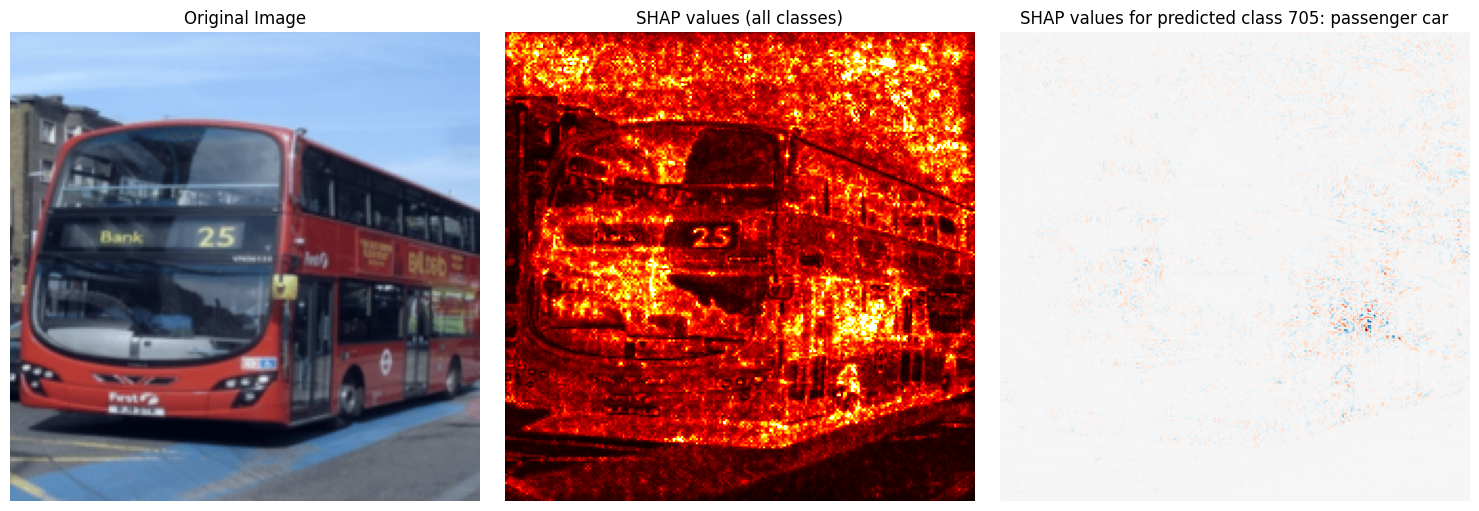


SHAP Values Summary:
  Predicted class 705: passenger car
  Mean absolute SHAP value (all classes): 0.0061
  Max absolute SHAP value (all classes): 0.5131
  Mean absolute SHAP value (predicted class 705): 0.0110
  Max absolute SHAP value (predicted class 705): 0.4788
SHAP explanation plot saved to /content/drive/My Drive/XAI_sample/shap_explanation.png


<Figure size 640x480 with 0 Axes>

In [ ]:
def get_imagenet_label(class_index):
    # URL of the ImageNet class index JSON file
    url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

    # Download the JSON file
    response = requests.get(url)
    class_labels = json.loads(response.text)

    # ImageNet classes are zero-indexed, so we don't need to subtract 1
    return class_labels[class_index]

# Usage
predicted_class = 705  # Your predicted class
label = get_imagenet_label(predicted_class)
print(f"Predicted class {predicted_class} corresponds to: {label}")

def plot_shap_values(input_tensor, shap_values, predicted_class):
    # Prepare the image data for visualization
    img_data = input_tensor.squeeze().permute(1, 2, 0).numpy()

    # Normalize image data for display
    img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min())

    # Convert shap_values to numpy array if it's not already
    shap_values_array = np.array(shap_values)

    # Visualize the SHAP values
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(img_data)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(132)
    if shap_values_array.shape == (1, 3, 224, 224, 1000):
        # Sum over all classes and the batch dimension
        shap_sum = np.abs(shap_values_array).sum(axis=-1).sum(axis=0)
        # Sum over color channels
        shap_sum = shap_sum.sum(axis=0)
    else:
        raise ValueError(f"Unexpected SHAP values shape: {shap_values_array.shape}")

    plt.imshow(shap_sum, cmap='hot', vmin=0, vmax=np.percentile(shap_sum, 99))
    plt.title("SHAP values (all classes)")
    plt.axis('off')

    plt.subplot(133)
    if shap_values_array.shape == (1, 3, 224, 224, 1000):
        class_shap = shap_values_array[0, :, :, :, predicted_class].sum(axis=0)
    else:
        raise ValueError(f"Unexpected SHAP values shape: {shap_values_array.shape}")

    plt.imshow(class_shap, cmap=plt.get_cmap('RdBu'), vmin=-np.abs(class_shap).max(), vmax=np.abs(class_shap).max())
    label = get_imagenet_label(predicted_class)
    plt.title(f"SHAP values for predicted class {predicted_class}: {label}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print SHAP values summary
    print(f"\nSHAP Values Summary:")
    print(f"  Predicted class {predicted_class}: {label}")
    print(f"  Mean absolute SHAP value (all classes): {np.abs(shap_values_array).mean():.4f}")
    print(f"  Max absolute SHAP value (all classes): {np.abs(shap_values_array).max():.4f}")
    print(f"  Mean absolute SHAP value (predicted class {predicted_class}): {np.abs(shap_values_array[0, :, :, :, predicted_class]).mean():.4f}")
    print(f"  Max absolute SHAP value (predicted class {predicted_class}): {np.abs(shap_values_array[0, :, :, :, predicted_class]).max():.4f}")

    # Save the plot
    plt.savefig('/content/drive/My Drive/XAI_sample/shap_explanation.png')
    print("SHAP explanation plot saved to /content/drive/My Drive/XAI_sample/shap_explanation.png")

# Usage:
plot_shap_values(input_tensor, shap_values, predicted_class)

### Evaluation of the SHAP Explanation

The SHAP explanation visualization highlights key areas of the bus image, marked in color, that contribute to the model's decision to classify the bus as a passenger car. From the visualization, we can see that parts of the bus’s wheels, side, front, and even portions of the sky play a role in influencing the prediction.

The **max absolute SHAP value (predicted class 705)** is **0.4788**, which indicates that one specific feature significantly impacts the model’s decision. SHAP values quantify the contribution of each feature to the difference between the actual prediction (passenger car) and the mean prediction across all possible classes. A max SHAP value of 0.4788 suggests that a particular feature—highlighted in the SHAP visualization—plays a substantial role in shifting the model's output toward the passenger car class. Compared to the mean prediction, this feature drives the model's classification with a considerable impact.

Overall, the SHAP explanation falls short compared to LIME and Anchors. The visualization is difficult to interpret, as the highlighted colors blend into the background, making it hard to distinguish the important features. Additionally, the **SHAP Gradient Explainer** took more than **2 hours** to run on a **Nvidia L4 GPU**, which is highly time-consuming and inefficient. In contrast, both LIME and Anchors generated their explanations in a matter of seconds using the same GPU. Considering both the **explanation clarity** and **computational efficiency**, I would not recommend SHAP for image explanations in this context.


## Detailed Analysis of Choosing LIME for the Bus Image Classification

After experimenting with three different explainable AI (XAI) techniques—**LIME**, **Anchors**, and **SHAP**—I chose **LIME** as the most suitable explanation technique for the bus image classification task. This decision was based on several factors, including its interpretability, computational efficiency, and overall effectiveness in providing a clear explanation of why the ResNet34 model incorrectly classified the bus image as a passenger car.

### Strengths of LIME for This Task

1. **Interpretability**:
   LIME provides **visual explanations** that are **highly intuitive** for image classification tasks. It highlights important image regions (in this case, parts of the bus) that contribute to the model's predictions. For example, in the bus image classification, the LIME explanation clearly shows that the model focused on parts of the bus door, wheels, upper side bus windows, and even the sky to predict the image as a **passenger car**. These visual cues are straightforward to interpret and allow us to understand the model's reasoning, even though the prediction was incorrect. While **Anchors** provides a reasonable explanation with high precision, the visualization is less intuitive compared to LIME. It’s noteworthy that Anchors is designed to address some of LIME’s limitations by offering a more robust explanation, yet the resulting visualization can feel less clear and interpretable in practice. This intuitive visual feedback is one of the key strengths of LIME, making it easy to explain model decisions to both technical and non-technical audiences.

2. **Efficiency**:
   One of the main reasons for selecting LIME was its **computational efficiency**. Compared to other XAI methods like **SHAP**, which took more than 2 hours to run with a **Nvidia L4 GPU**, LIME was able to generate explanations in just **seconds** using the same GPU. This makes LIME highly suitable for tasks where quick insights are needed, especially when experimenting with large datasets or complex models like ResNet34. Given that LIME only approximates the local decision boundary and doesn’t require retraining the model or running complex gradient computations, it is far more **lightweight** in terms of resource usage.

3. **Flexibility**:
   LIME is **model-agnostic**, meaning it can be applied to any black-box model, including deep learning models like ResNet34. This flexibility is particularly valuable in the context of image classification, where models can be swapped or updated without the need to change the explanation technique. LIME works effectively across various image classification models and can easily adapt to changes in the underlying architecture without losing its ability to provide explanations.

4. **Local Approximation**:
   LIME’s ability to focus on **local explanations** is well-suited for this task. By approximating the local decision boundary around the instance of interest (the bus image), LIME provides insights into why the model made a specific prediction rather than explaining the global behavior of the model. In this case, the local approximation around the bus image shows that the ResNet34 model misclassified the bus as a passenger car due to its focus on specific features, such as the wheels and the bus door, which in isolation resemble features of a car.

### Limitations of LIME in This Scenario

1. **Inconsistency Across Perturbations**:
   One limitation of LIME is that its explanations can be **inconsistent across different perturbations** of the image. LIME perturbs the input image by segmenting it into superpixels and altering them to create variations of the image. Since this process involves randomness, the explanation generated for the same input image might slightly change depending on the perturbations. This can lead to some **instability** in the explanation, which might be a concern when consistency is crucial. In the bus image classification task, this inconsistency is not a major issue but can affect the reliability of explanations when making fine-grained decisions.

2. **Oversimplified Explanations**:
   Another limitation of LIME is its tendency to **oversimplify** the model's behavior due to its use of **linear approximations**. ResNet34 is a highly **nonlinear** model, and by approximating the decision boundary using a linear model in the vicinity of the input, LIME may not capture the full complexity of the model’s decision-making process. For example, the classification of the bus as a passenger car involves complex interactions between multiple features, which may not be fully captured by the linear surrogate model used by LIME. In this case, while LIME provides a clear and intuitive explanation, it might miss some of the underlying complexity of ResNet34’s internal decision-making.

3. **Bias in Explanation**:
   LIME’s explanation can sometimes focus on **irrelevant regions** of the image, leading to **biased explanations**. In the bus image, for instance, LIME highlights parts of the sky, which might not be relevant for distinguishing between a bus and a passenger car. This potential bias could make the explanation less useful in certain situations, as the highlighted regions may not always align with human intuition about what should be important for classification.

### Potential Improvements to the Approach

1. **Optimizing Superpixel Segmentation**:
   One way to improve the accuracy of LIME’s explanations is to **carefully tune the superpixel segmentation** process. By adjusting the size and granularity of the superpixels, it might be possible to capture more meaningful segments of the image that contribute to the prediction. For example, finer segmentation could help separate key features like the bus windows, wheels, and body, leading to a more accurate and detailed explanation.

2. **Combining LIME with Other Techniques**:
   To address LIME’s potential limitations in oversimplifying complex models, it could be beneficial to **combine LIME with other XAI techniques** like **Anchors**. Anchors provides rule-based explanations that capture important feature interactions. A hybrid approach could help balance LIME’s intuitiveness and computational efficiency with Anchors’ ability to handle nonlinearities and provide more robust, rule-based explanations.

3. **Use of Additional Perturbation Methods**:
   To mitigate the issue of **inconsistent explanations**, it may be useful to introduce more controlled or **domain-specific perturbation methods**. Instead of randomly perturbing the image, a more structured approach that considers the domain (e.g., ensuring that the bus’s critical features are perturbed systematically) could lead to more consistent and reliable explanations.

### Conclusion

In summary, **LIME** was chosen for this bus image classification task because it provides the most **intuitive** and **computationally efficient** explanation. Despite some limitations like **inconsistency across perturbations** and **potential bias in the highlighted regions**, LIME offers clear visual feedback that helps explain why the ResNet34 model misclassified the bus as a passenger car. By focusing on local explanations and being highly flexible and model-agnostic, LIME is well-suited for tasks that require fast, interpretable insights. With potential improvements like optimizing superpixel segmentation and combining LIME with other XAI methods, LIME could become an even more effective tool for understanding complex model behavior.
